In [120]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from itertools import compress

import seaborn as sns
from pandas_profiling import ProfileReport

from matplotlib import pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [2]:
df = pd.read_json('/data/20221125_path_data.json')

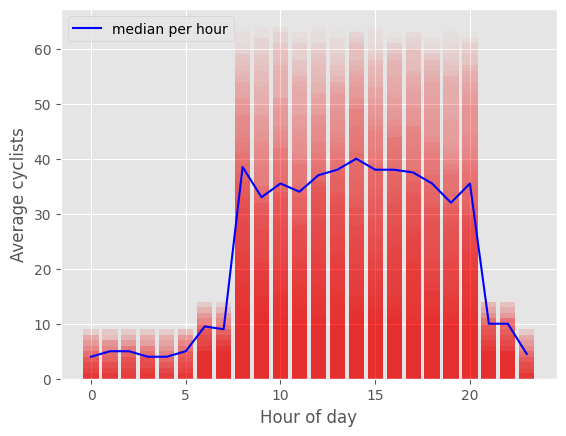

In [48]:
# lets plot the distributions of cyclist average

for i, row in df.iterrows():
    plt.bar(x=range(0, 24), height=row["cyclists_average"], alpha=0.01, color="r")

plt.plot(
    np.median(np.array(df["cyclists_average"].to_numpy().tolist()), axis=0),
    color="b",
    label="median per hour",
)

plt.xlabel("Hour of day")
plt.ylabel("Average cyclists")

plt.legend()
plt.show()

In [63]:
# we convert the cyclist_average column to a numpy matrix
cyclists_avg_col = np.array(df["cyclists_average"].to_numpy().tolist())

In [124]:
# lets reaggregate the average cyclists to morning/afternoon/evening/night

df["average_morning"] = cyclists_avg_col[:, 8:12].mean(axis=1)
df["average_afternoon"] = cyclists_avg_col[:, 12:18].mean(axis=1)
df["average_evening"] = cyclists_avg_col[:, 18:21].mean(axis=1)
df["average_night"] = cyclists_avg_col[
    np.ix_(range(0, 100), [0, 1, 2, 3, 4, 5, 6, 7, 21, 22, 23])
].mean(axis=1)

In [125]:
# exploring the dataset using pandas profiler with the additional columns

profile = ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

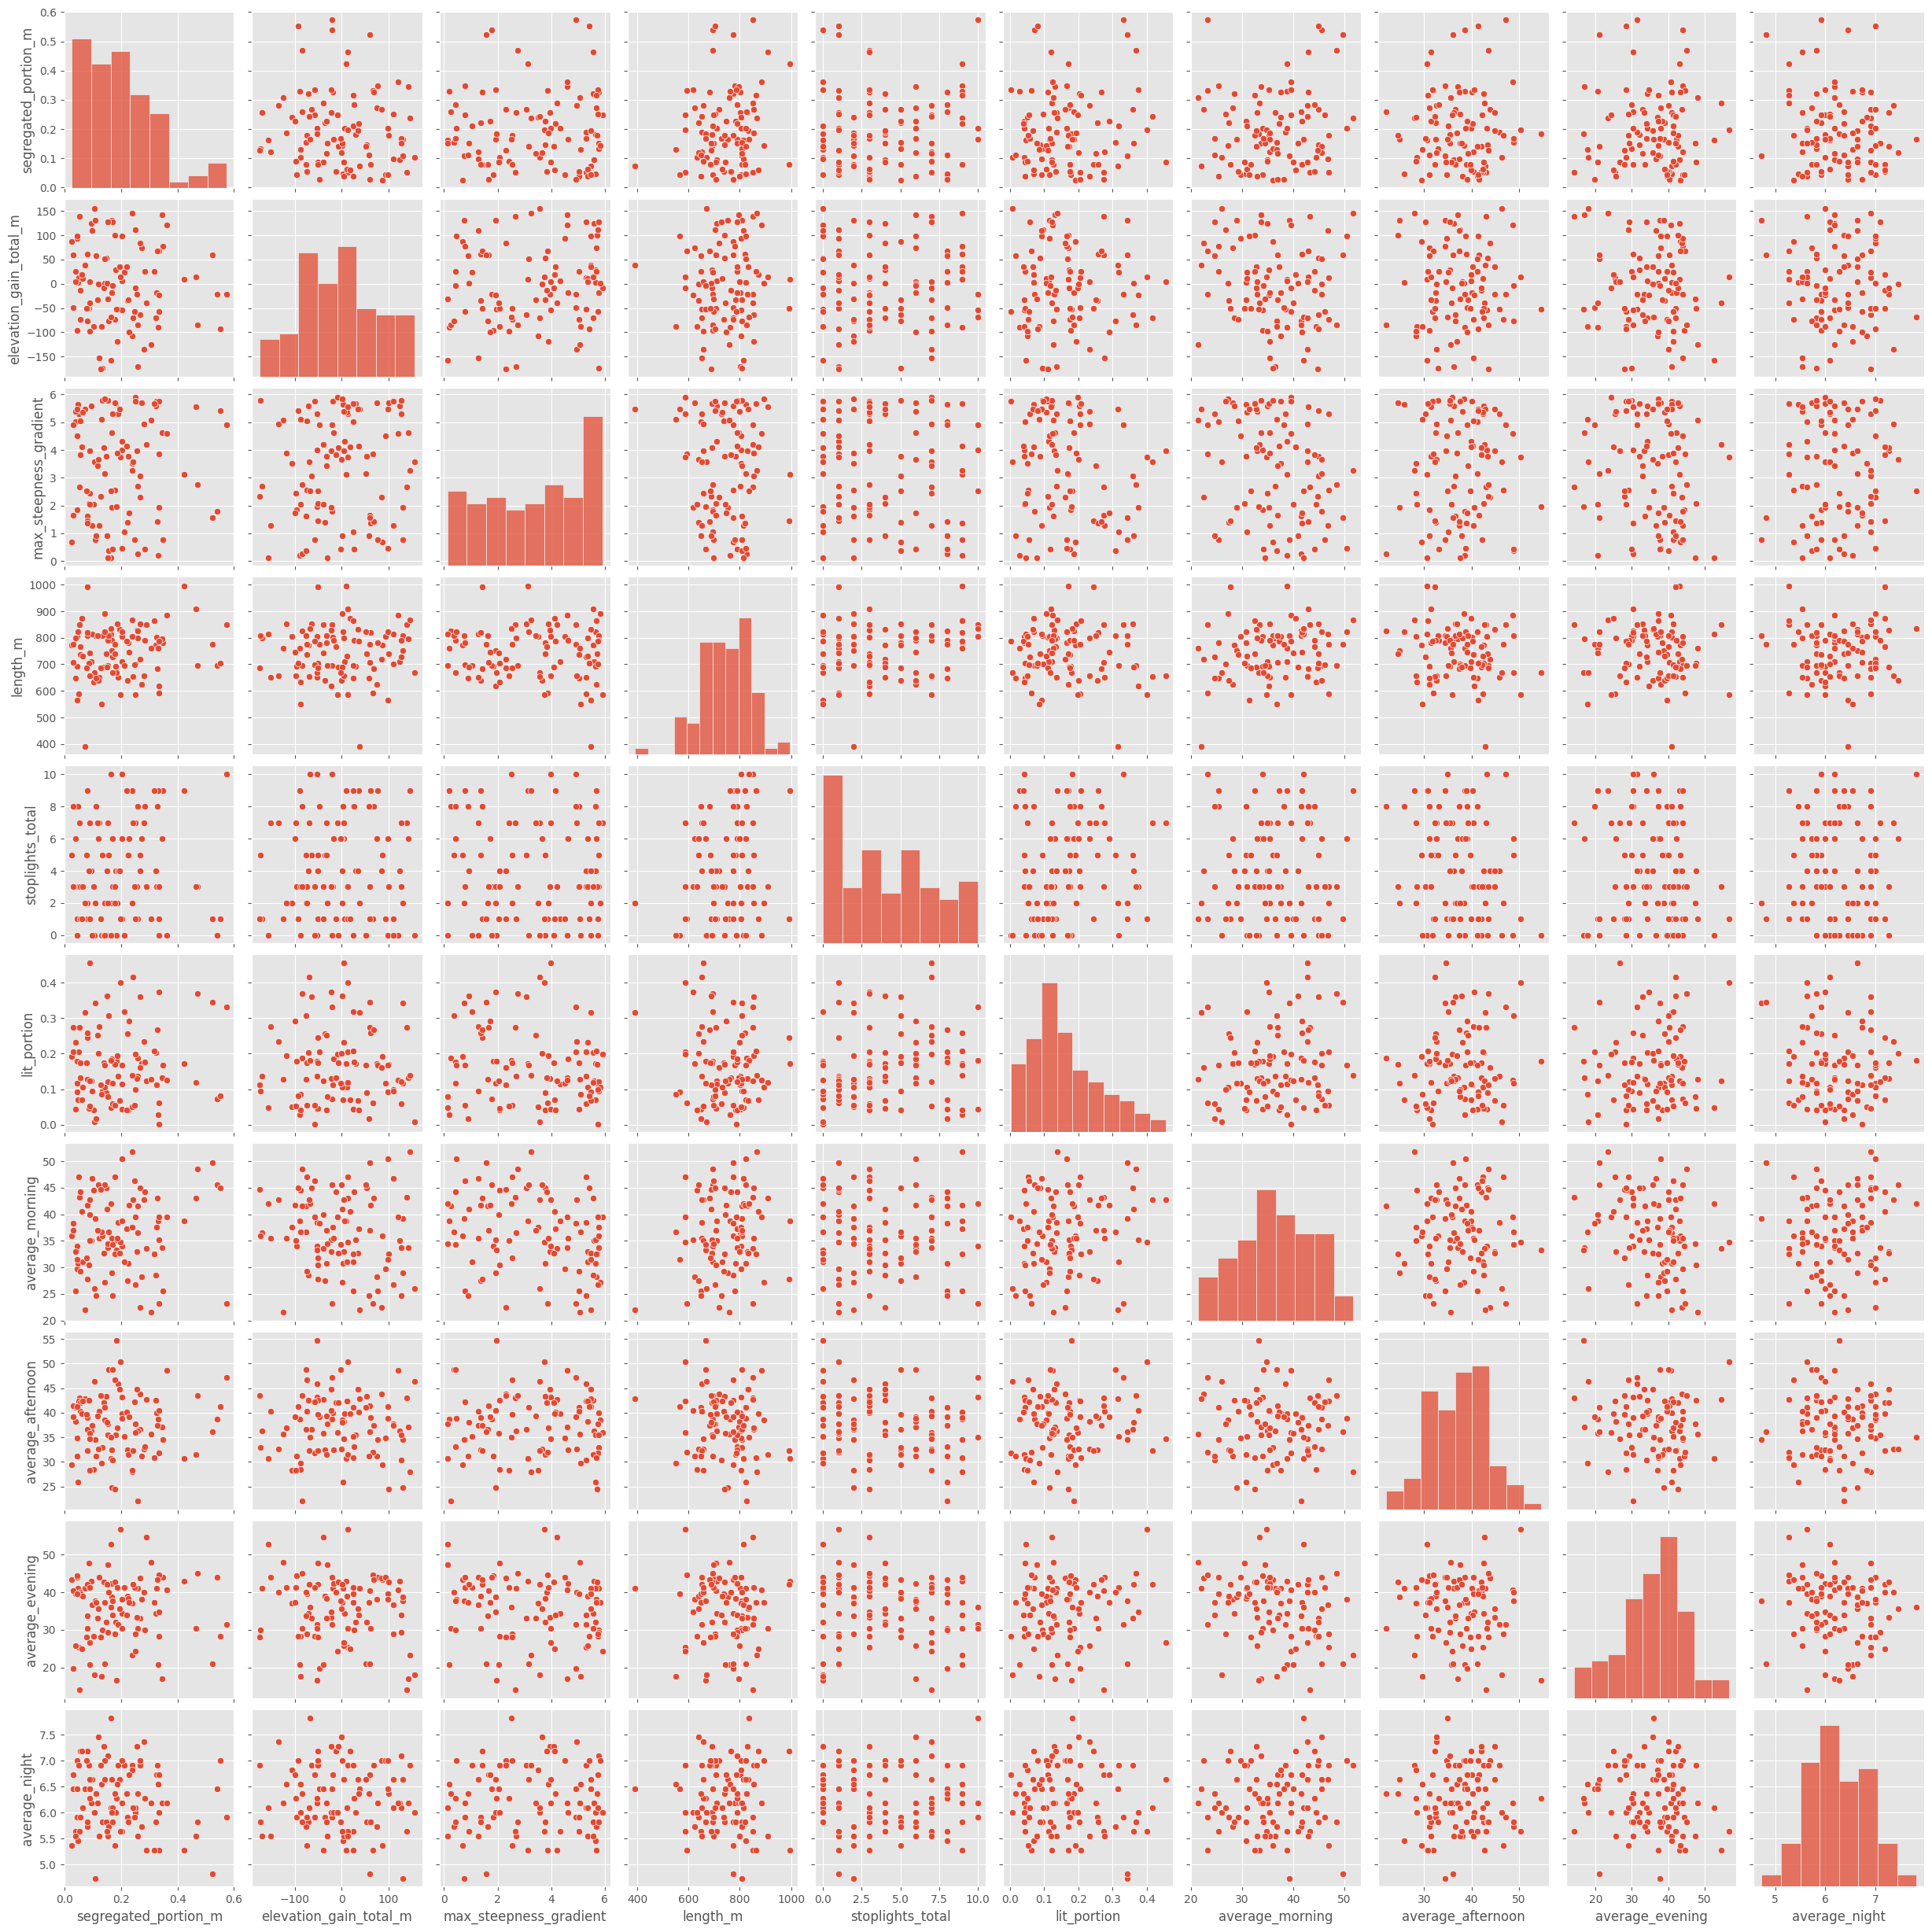

In [126]:
# plot dataset correlations
sns.pairplot(
    df[
        [
            "segregated_portion_m",
            "elevation_gain_total_m",
            "max_steepness_gradient",
            "length_m",
            "stoplights_total",
            'lit_portion',
            'average_morning',
            'average_afternoon',
            'average_evening',
            'average_night'
            
        ]
    ]
)

In [167]:
# lets see which variables are important
X_cols = [
    "segregated_portion_m",
    "elevation_gain_total_m",
    "max_steepness_gradient",
    "length_m",
    "stoplights_total",
    "lit_portion",
]

for tod in ["average_morning", "average_afternoon", "average_evening", "average_night"]:

    X = df[X_cols].values
    y = df[tod].values.reshape(
        -1,
    )

    clf_morning = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10]).fit(X, y)

    score_ = clf_morning.score(X, y)

    print(f"Fitting score for {tod} is {score_}")

    selector = SelectFromModel(clf_morning).fit(X, y)

    print(
        f"Important variables for {tod} is {list(compress(X_cols, selector.get_support()))}"
    )

Fitting score for average_morning is 0.10656789115067189
Important variables for average_morning is ['elevation_gain_total_m', 'max_steepness_gradient', 'length_m']
Fitting score for average_afternoon is 0.046912215014434544
Important variables for average_afternoon is ['elevation_gain_total_m', 'length_m', 'stoplights_total']
Fitting score for average_evening is 0.016212378486608614
Important variables for average_evening is ['elevation_gain_total_m', 'length_m']
Fitting score for average_night is 0.0
Important variables for average_night is []


In [168]:
# establishing difficulties?

df["segregated_difficulty"] = pd.qcut(
    df["segregated_portion_m"], [0, 0.25, 0.5, 0.75, 1], labels=[4, 3, 2, 1]
)
df["elevation_difficulty"] = pd.qcut(
    df["elevation_gain_total_m"], q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4]
)
df["steepness_difficulty"] = pd.qcut(
    df["max_steepness_gradient"], q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4]
)
df["length_difficulty"] = pd.qcut(
    df["length_m"], q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4]
)
df["stoplights_difficulty"] = pd.qcut(
    df["stoplights_total"], q=[0, 0.25, 0.5, 0.75, 1], labels=[1, 2, 3, 4]
)

In [169]:
df["mean_difficulty"] = df[df.columns[-5:]].to_numpy().mean(axis=1)

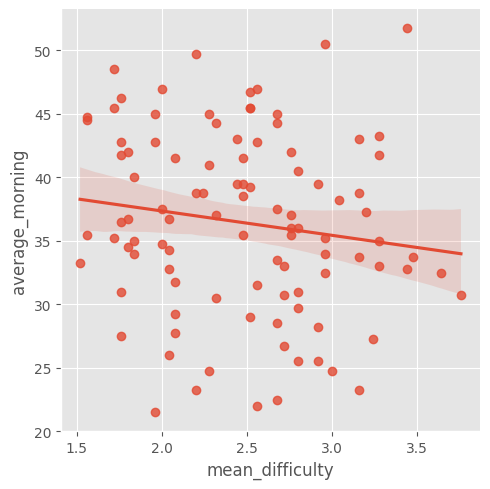

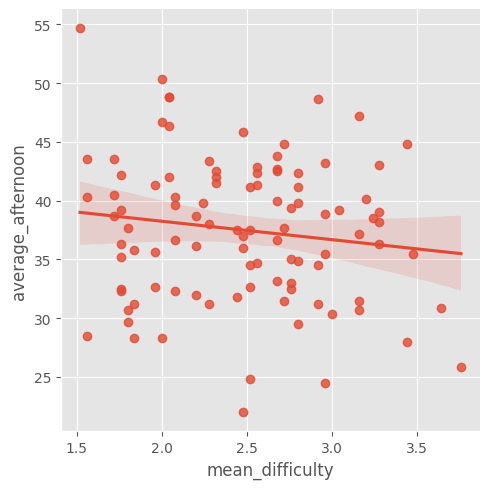

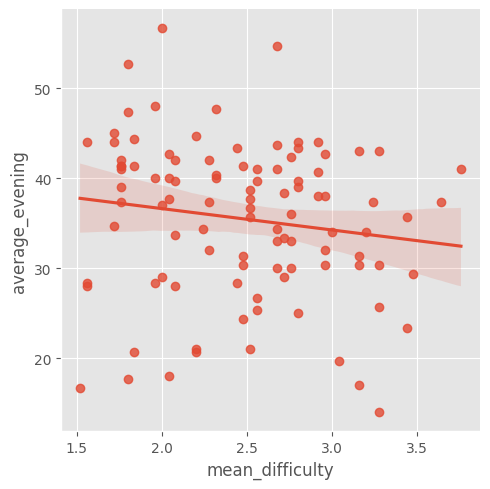

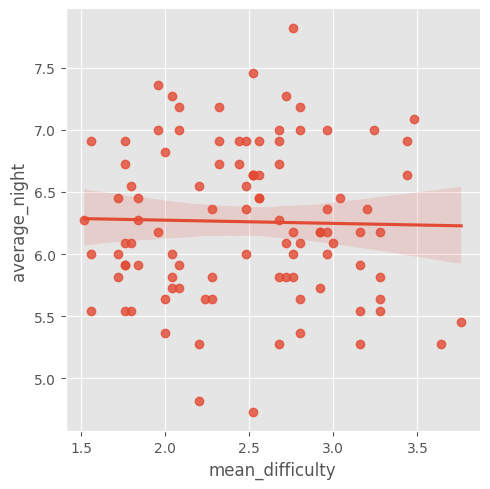

In [170]:
for tod in ["average_morning", "average_afternoon", "average_evening", "average_night"]:

    sns.lmplot(x="mean_difficulty", y=tod, data=df)

# Summary
* We tried to explore any signal in the data that could inform the question
* We assumed that the volume of cyclists could be an indication on route preference
* We reaggregated the hourly counts to times of day to reinforce the signal and partially adjust for exposure
    * Strong assumption. A busyness of a route doesn't necessarily mean that the riders experience an easier journey
* We used a Lasso regression model to explore the significance of the predictors. It was found that lit_portion was not informative in the context of time of day volumes
* We roughly recategorised the covariates to ordinal variables using quantiles (low/high path difficulty). From those we extract the mean path difficulty
* We explored the mean path difficulty in the context of time of day volumes
    * There exist an intuitive relation between the mean difficulty and ride volumes: the harder the path the fewer the riders
    * The signal for the night time of day too weak to draw any conclusions

# What could be done in the future
* We need to better adjust for exposure to normalise the cyclist counts
    * Using traffic density or footfall per area
    * Using population density
* If we had knowledge on the geographical location of the count sensors we could control for spatial correlation
    * We would expect nearby sensors to be more corellated
    * We could capture the neighboring structure of the sensors or simply include the coordinates as covariates
* We could one hot encode the quantile based difficulty levels and treat them as covariates
* We could unroll the individual counts to the dataset to gain a long representation. We could add temporal covariates (using cyclic representation at the very least) within a non linear model (e.g. using ensemble methods)
* We could explore more covariates that are likely correlated with path difficulty
    * Road network characteristics: road class, form of way, speed limit etc.
    * Network centrality metrics
    * Land use variables (e.g. residential area)
    * Proximity to features (e.g. parks, universities, schools etc.)
* Ultimately we would need to validate the results
    * Directly using custom surveys
    * Indirectly using secondary data (e.g. national travel survey, active life survey)
